In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
df1=pd.read_csv('Chicago_Crimes_2012_to_2017.csv',engine='python',error_bad_lines=False)

df1.head(2)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"


Load the data set

In [0]:
df1.columns

In [0]:
df=df1
df.shape

(1456714, 23)

In [0]:
df.drop(['Unnamed: 0','ID','Case Number','Updated On','Latitude','Longitude', 'Location','IUCR'],axis=1,inplace=True)
df.columns

**Crime distribution over month**

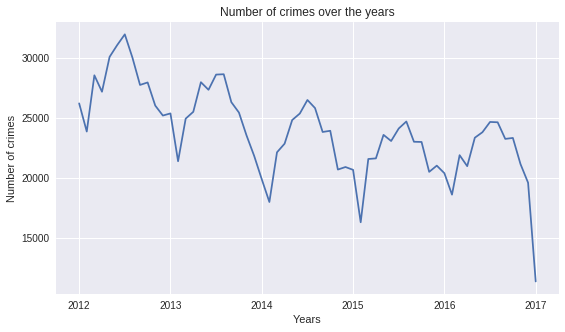

In [0]:
df=df[(df.Date != '046XX N CUMBERLAND AVE')]
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')
df.index = pd.DatetimeIndex(df.Date)
plt.figure(figsize=(9,5))
df.resample('M').size().plot(legend=False)
plt.title('Number of crimes over the years')
plt.xlabel('Years')
plt.ylabel('Number of crimes')
plt.show()

From above dataframe, i am converting it on day basis series to forecast day data. we can also use week, month forcasting kind of dataset. 

### Dataframe creation

In [0]:
def create_day_series(df1):
    
    
    day_df = pd.Series(df1.groupby(['Date']).size())
    # setting Date/Time as index
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling to daily trips
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

df_day = create_day_series(df)
df_day.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


Date
2012-01-01    1451
2012-01-02     700
2012-01-03     805
2012-01-04     799
2012-01-05     871
Freq: D, dtype: int64

we can see that each row corresponds to a date with count of crime on that day

start and end of the data

In [0]:
print (df_day.index.min())
print (df_day.index.max())

2012-01-01 00:00:00
2017-01-18 00:00:00


## Plotting the data set

We will use the sARIMA model for time series forcasting of the data.

setting the different library for the same.

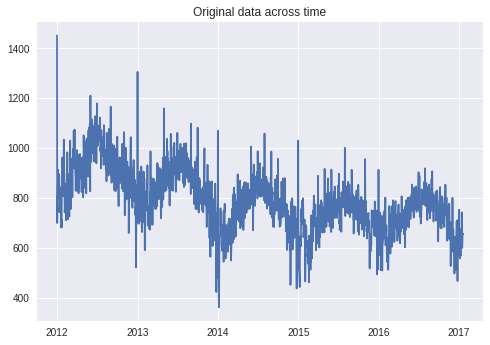

In [0]:
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
def initial_plots(time_series):
    plt.figure(1)
    plt.plot(time_series)
    plt.title('Original data across time')

    plt.show()
    
initial_plots(df_day)

## Test Stationary

We will get an idea about the overall trend and seasonality of the series. Then, we will use a statistical method to assess the trend and seasonality of the dataset. After trend and seasonality are assessed if they are present in the dataset, they will be removed from the series to transform the nonstationary dataset into stationary and the residuals are further analyzed.

### Test stationary using Dickey-Fuller

In [0]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10,rotation=90)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 15)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [0]:
def TestStationaryAdfuller(ts, cutoff = 0.05):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

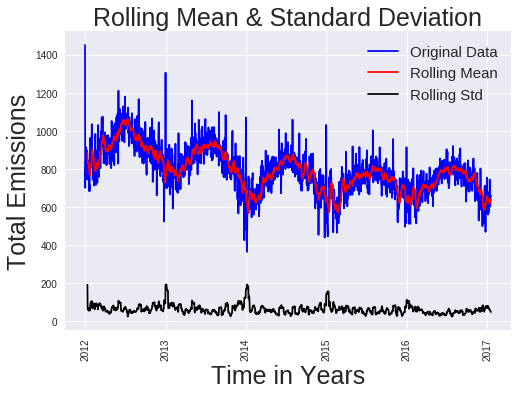

In [0]:
TestStationaryPlot(df_day)

In [0]:
TestStationaryAdfuller(df_day)

Test Statistic                   -1.901301
p-value                           0.331449
#Lags Used                       22.000000
Number of Observations Used    1822.000000
Critical Value (1%)              -3.433944
Critical Value (5%)              -2.863128
Critical Value (10%)             -2.567615
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Comment:- 


From above mean (red) and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary.

### Eliminating trend and seasonality using >> Differencing

First order differencing can be done

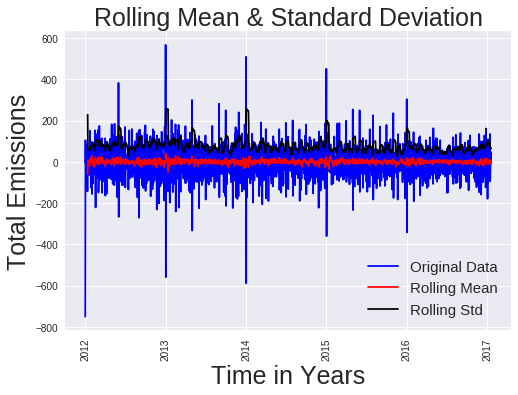

In [0]:
df_first = df_day - df_day.shift(1)  
TestStationaryPlot(df_first.dropna(inplace=False))

In [0]:
TestStationaryAdfuller(df_first.dropna(inplace=False))
df_first=df_first.dropna(inplace=False)

Test Statistic                -1.180022e+01
p-value                        9.369173e-22
#Lags Used                     2.500000e+01
Number of Observations Used    1.818000e+03
Critical Value (1%)           -3.433952e+00
Critical Value (5%)           -2.863131e+00
Critical Value (10%)          -2.567617e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


** Comment**

 First difference improves the stationarity of the series. we could able to convert the series in stationary format.

### Checking Decomposing >> Eliminating trend and seasonality

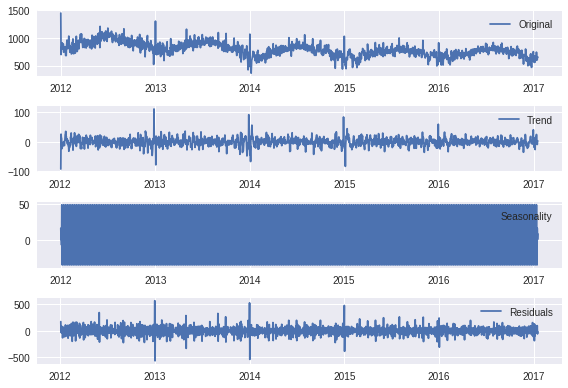

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_first)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### ACF and PACF plot and finding the optimal parameters

 Tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation graphs.

<Figure size 576x396 with 0 Axes>

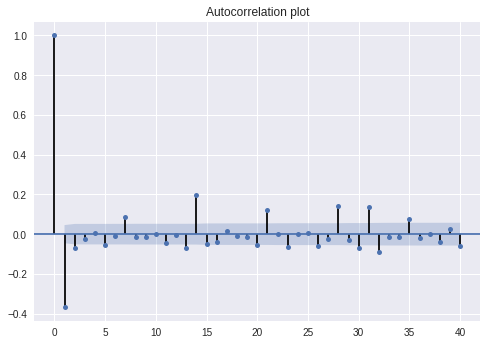

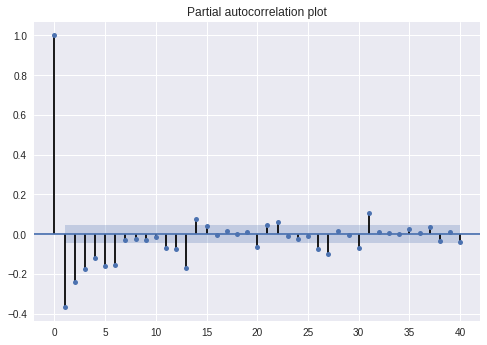

In [0]:
plt.figure(2)
plot_acf(df_first, lags = 40)
plt.title('Autocorrelation plot')
plot_pacf(df_first, lags = 40)
plt.title('Partial autocorrelation plot')

plt.show()

In [0]:
# pending this partfitting model

### SARIMA Model (p, d, q)(P, D, Q, S):

I have take value of parameter  (p, d, q)(P, D, Q, S) as (1,2,1)(0,1,1,12) that can further be tuned.

In [0]:
mod = sm.tsa.statespace.SARIMAX(df_day, 
                                order=(1,2,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1845
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood              -10459.856
Date:                            Sat, 16 Feb 2019   AIC                          20927.712
Time:                                    05:14:07   BIC                          20949.793
Sample:                                01-01-2012   HQIC                         20935.853
                                     - 01-18-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3783      0.014    -26.729      0.000      -0.406      -0.351
ma.L1         -1.0000     11.337   

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


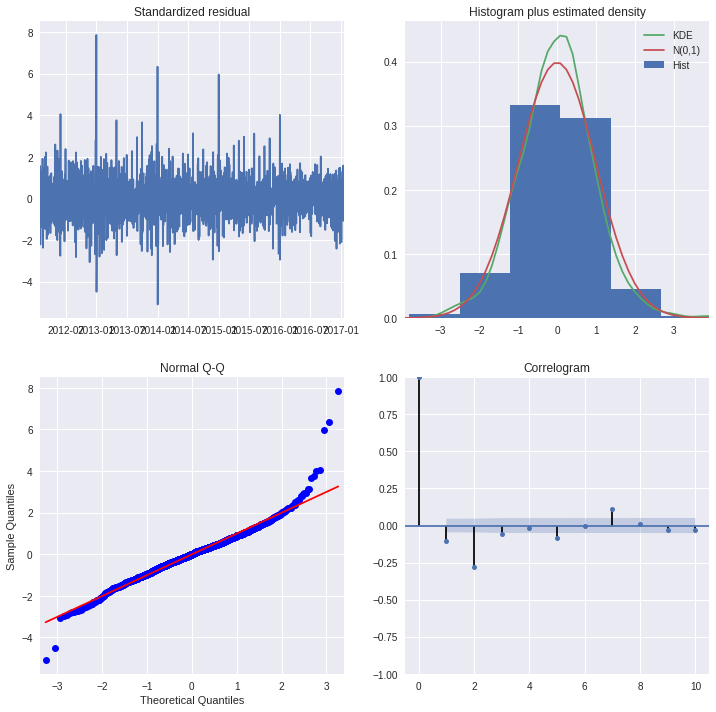

In [0]:
results.plot_diagnostics(figsize=(12, 12))
plt.show()

Residuals of model should be  uncorrelated and normally distributed with zero-mean

In [0]:
pred = results.get_prediction(start = 1750, end = 1850, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower y,upper y
2016-10-16,654.746644,950.672567
2016-10-17,635.502223,931.427744
2016-10-18,638.676598,934.601584
2016-10-19,621.518693,917.442905
2016-10-20,563.779287,859.700023


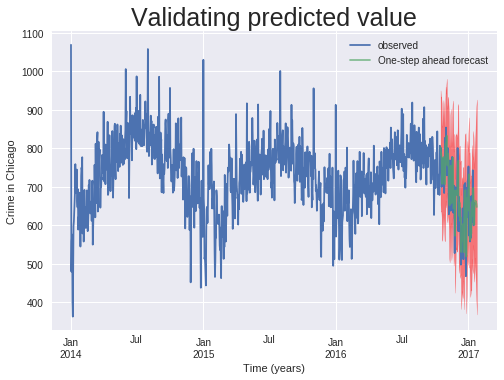

In [0]:
ax = df_day['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Crime in Chicago')
plt.title('Validating predicted value', fontsize = 25)
plt.legend()
plt.show()

In [0]:
df_forecast = pred.predicted_mean
df_orginal = df_day['2016-10-16':]

# Compute the mean square error
mse = ((df_forecast - df_orginal) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((df_forecast-df_orginal)**2)/len(df_forecast))))

Tuning of ARIMA parameter  (p, d, q)(P, D, Q, S) will get the better results. 

Grid serch approch can be taken to select/tune the parameter with AIC score, 

As that part take around 2-3 hours to tune I have left that part due to my system issue and currently Iam out of station due to some office work so have  time constraints.

## Thanks